# Script to azimutally integrate 2D scattering images to 1D curves

How to do

## Preparations
### Import Libraries

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap
import fabio
import pyFAI
from pyFAI.detectors import Pilatus1M
from scipy import optimize
import scipy.constants as con
import os
import pandas as pd

### custom colormap

In [25]:
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
          
         'alpha': ((0.0, 0.0, 0.0),
                   (1.0, 0.7, 0.7))
         }
red_alpha = LinearSegmentedColormap('red_alpha', cdict)
plt.register_cmap(cmap=red_alpha)

## Read and display single images for instrumental calibration

{
  "HeaderID": "EH:000001:000000:000000",
  "ByteOrder": "LowByteFirst",
  "DataType": "SignedInteger",
  "Size": "4092732",
  "Dim_1": "981",
  "Dim_2": "1043",
  "Image": "0",
  "acq_frame_nb": "0",
  "time": "Fri May  5 16:05:42 2017",
  "time_of_day": "1493993142.631347",
  "time_of_frame": "-12345678901234567168.000000",
  "F2K": "0",
  "FrameNumber": "1/2",
  "FrameTime": "30.000000",
  "I2": "0",
  "Monitor": "6440970",
  "P1M": "0",
  "P1M3S": "1",
  "P300K": "1",
  "Photo": "3464354",
  "SHUT": "1",
  "Volume": "-0.135000",
  "XMotor 35": "11.5825",
  "Xmicro": "0",
  "Ymicro": "0",
  "ZMotor 36": "16.442",
  "Zmicro": "0.0199883",
  "axmo_x": "-106.76",
  "axmo_z": "-15",
  "beamstX": "-47.7",
  "beamsty": "49.94",
  "bstopb": "271.798",
  "bstopt": "-364.475",
  "col_beg": "0",
  "col_end": "980",
  "count_time": "30",
  "detectX": "179.637",
  "detectY": "269.118",
  "detector": "PILATUS3 1M, S/N 10-0154",
  "diode": "44",
  "dir": "/data/visitor/ch4930/bm26/ag_be/SAXS",
 

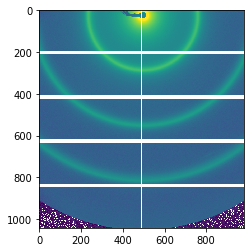

In [32]:
# give the image directory
image_dir = 'C:\\Users\\eikeg\\Documents\\Science\\qe05_ESRF\\3th-reaction'
# give the generic image name and file ending (e.g. >.tif<)
image_name = 'ag_be_SAXS_'
image_type = '.edf'

# give the number of the image you like to display
image_number = '0001'

image_path = image_dir + os.sep + image_name + image_number + image_type
image_object = fabio.open(image_path)
image = image_object.data
print(image_object.header)

fig, ax = plt.subplots()
ax.imshow(image, norm=LogNorm())

## Calibrate beam center and distance
### Find the beam center on the detector

In [28]:
# some general function needed for that

# a gaussian circle
def gauss_circle(x, y, x0, y0, r, sigma):
    return np.exp(-(np.sqrt((x0 - x)**2+(y0 - y)**2) - r)**2 / (2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

# a simple circle
def in_circle(x, y, x0, y0, r):
    return (x - x0)**2 + (y - y0)**2 < r**2

# fitfunction 
def fun(x):
    x0, y0, r = x
    fun_val = -np.sum(image * gauss_circle(X, Y, x0, y0, r, sigma) * mask)\
    / np.sum(gauss_circle(X, Y, x0, y0, r, sigma) * mask)
    return fun_val

In [29]:
# for preparations for the image

# produce a meshgrid with x and y components
X, Y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))

# automated masking of negative values and hot-pixels or areas with much to high count
def create_mask(img, *args, ul=1e6, ll=0):
    mask = img < ll
    mask[img > ul] = True
    for arg in args:
        mask[arg] = True
    return mask

In [30]:
# Center search by circle fitting of a bragg peak

# give starting parameters
x0 = 500
y0 = 23
radius = 250
sigma = 1

# mask the center of the image to ease the optimization procedure
radius_centerMask = 100
mask = ~create_mask(image, in_circle(X, Y, x0, y0, radius_centerMask))

res = optimize.minimize(fun, [x0, y0, radius], method='Nelder-Mead')
res

 final_simplex: (array([[497.66328167,  25.23008408, 262.18951838],
       [497.66327809,  25.23001455, 262.1895786 ],
       [497.66330588,  25.23009686, 262.18954488],
       [497.66332564,  25.22999868, 262.18957204]]), array([-15365.59685532, -15365.59685528, -15365.59685519, -15365.59685516]))
           fun: -15365.596855316266
       message: 'Optimization terminated successfully.'
          nfev: 154
           nit: 87
        status: 0
       success: True
             x: array([497.66328167,  25.23008408, 262.18951838])

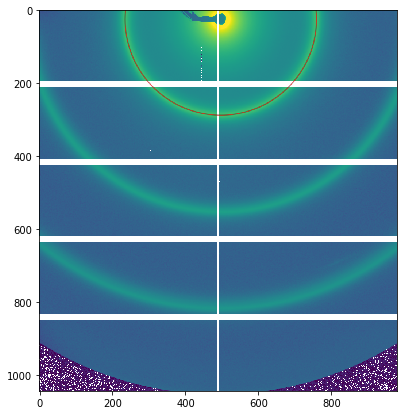

In [31]:
# Plot test image with fitted circle
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(image, norm=LogNorm())
ax.imshow(gauss_circle(X, Y, res['x'][0], res['x'][1], res['x'][2], sigma), cmap='red_alpha')

### calculate distance
$q = \frac{4\pi}{\lambda}\cdot\sin{\theta}$


$\tan{2\theta} = \frac{\mathrm{radius}}{\mathrm{dist}}$


$\mathrm{dist} = \mathrm{radius}\cdot(\tan{2\theta})^{-1} = \mathrm{radius} \cdot (\tan{(2\arcsin{\frac{q \lambda}{4\pi}})})^{-1}$

In [51]:
# give the pixel size in meter
pixelsize = 172e-6

# give the position of the before fitted bragg peak
# for Silver-Behenate (Ag-beh) 1.070057 nm^-1
q_peak = 1.076  # in nm^-1

# give the experimental X-ray energy
energy_calibration = 11993 # in eV

#calculate wavelength, scattering angle and sample to detector distance
wavelength = con.h * con.c / con.e / energy_calibration  # m
theta = np.arcsin(wavelength * 1e9 * q_peak/ 4 / np.pi)
dist = res['x'][2] * pixelsize / np.tan(2 * theta)  # m
print("sample-detector distance = {} m".format(round(dist, 5)))
print("Wavelength = {} Angstroem".format(round(wavelength*10**10, 5)))

sample-detector distance = 2.54696 m
Wavelength = 1.0338 Angstroem


## Azimuthal Integration

In [52]:
# for real data use also mask option of AI class
# notice that poni1 correspond to y and poni2 to x coordinate of detector
# for more information on geometry visit (figure at bottom of page):
# https://pyfai.readthedocs.io/en/latest/usage/tutorial/Geometry/geometry.html

ai = pyFAI.AzimuthalIntegrator(dist=dist, poni1=res['x'][1]*pixelsize, poni2=res['x'][0]*pixelsize,
                               detector=Pilatus1M(), wavelength=wavelength)
ai

  File "<ipython-input-52-dc60f8fbe1e6>", line 7, in <module>
    detector=Pilatus1M(), wavelength=wavelength)


Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.033805e-10m
SampleDetDist= 2.546958e+00m	PONI= 4.339574e-03, 8.559808e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 2546.958mm	Center: x=497.663, y=25.230 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

### Masking
Generate a mask file (as name.edf, name.tif, ...) and load it to ai_mask via ai_mask_path.
The recommended procedure is the following: 
1. open a python console or anaconda promped
2. optional change to the the image directory via >>cd path\to\data<<
3. type >>pyFAI-drawmask filename.tif<< or >>pyFAI-drawmask path\to\data\filename.tif<<

A GUI will open with the specified image file. With the GUI a mask can be generated and saved. 
Save it and use it below.

In [54]:
# adress the mask
ai_mask_path = image_dir + os.sep + 'qe05_ESRF_Mask.msk'
ai_mask_object = fabio.open(ai_mask_path)
ai_mask = ai_mask_object.data

# usage of integrate 1d method
q, I, e = ai.integrate1d(image, 800, error_model='poisson', mask=ai_mask)

### Do the integration

In [55]:
# usage of integrate 1d method
bin_number = 800 #how many data points are generated
q, I, e = ai.integrate1d(image, bin_number, error_model='poisson', mask=ai_mask)

[]

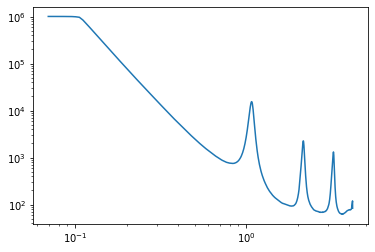

In [56]:
# Display the azimuthal integration result
scale = 1  # upscaling of poisson error for visibility

fig, ax = plt.subplots()
ax.fill_between(q, I + scale * e, I - scale * e, alpha=0.5)
ax.plot(q, I)
ax.loglog()
#ax.set_xlim([0.05, 1.81])

In [21]:
# for additional info uncomment line below
ai.integrate1d??

In [87]:
# Save Numpy array to csv with header
save_file_name = image_dir + os.sep + '1D_' + image_name + image_number + '.csv'
np.savetxt(save_file_name, np.column_stack((q, I, e)), delimiter=',', header='q in nm-1,I,poisson_error')

In [83]:
np.column_stack((q, I, e))

array([[1.28915955e-01, 3.34919609e+04, 4.46690719e+01],
       [1.43015377e-01, 2.41328164e+04, 2.05602303e+01],
       [1.57114799e-01, 1.67077031e+04, 1.31518806e+01],
       ...,
       [5.72638651e+00, 3.06960845e+00, 4.01895035e-01],
       [5.74048593e+00, 3.39244199e+00, 5.45127892e-01],
       [5.75458536e+00, 3.31642795e+00, 9.21597152e-01]])

### azimuthal integration 2d

In [57]:
# usage of integrate2d
I2d, q, chi = ai.integrate2d(image, 800, 360, error_model='poisson')

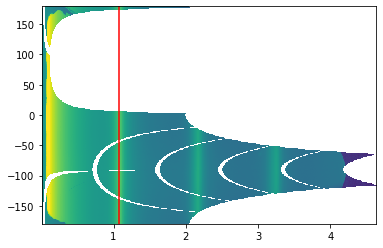

In [70]:
fig, ax = plt.subplots()
extent = [q.min(), q.max(), chi.min(), chi.max()]
ax.imshow(I2d, norm=LogNorm(), extent=extent, aspect='auto')
q_agbh = 1.070057  # nm^-1
ax.axvline(x=q_agbh, color='r')

## Batch integration
### scan trough directory and collect meta data

In [121]:
# import methadata
# give the methadada directory
data_dir = 'files\Data_for_ASAXS'
# how many useless header files are in?
number_of_header_lines = 375

# scan the directory
fileList = list()
for entry in os.scandir(data_dir):
    if entry.path.endswith('.dat') and entry.is_file():
        fileList.append(entry.path)
# make an path iterator from the found files
fileIterator = iter(fileList)

# generate the first pandas frame from the first entrie
element = next(fileIterator)
path_to_data = element
dataFrame = pd.read_csv(path_to_data, sep='\t',header=number_of_header_lines)
dataFrame = dataFrame.drop([0]) # drop the NaN lines

# append all other files
for element in fileIterator:
    path_to_data = element
    print(element)
    newDataFrame = pd.read_csv(path_to_data, sep='\t',header=number_of_header_lines)
    newDataFrame = newDataFrame.drop([0]) # drop the NaN lines
    dataFrame = dataFrame.append(newDataFrame)

# suggesting there is a '# ' directly before the first header entry, drop it
dfInitialColumnName = dataFrame.columns[0]
dfNewColumnName = dataFrame.columns.tolist()[0][2:]
dataFrame = dataFrame.rename(columns={dfInitialColumnName: dfNewColumnName}) # get rid of the '# ' in the first column name

# re-index the data frame 0 to the end
dataFrame = dataFrame.reset_index(drop=True)

print('Number of entries:', len(dataFrame))

files\Data_for_ASAXS\fcm_2020kw29tg14_00093.dat
files\Data_for_ASAXS\fcm_2020kw29tg14_00095.dat
files\Data_for_ASAXS\fcm_2020kw29tg14_00097.dat
files\Data_for_ASAXS\fcm_2020kw29tg14_00099.dat
files\Data_for_ASAXS\fcm_2020kw29tg14_00101.dat
files\Data_for_ASAXS\fcm_2020kw29tg14_00103.dat
files\Data_for_ASAXS\fcm_2020kw29tg14_00104.dat
Number of entries: 144


In [ ]:
# dataFrame

### use the integrator

In [ ]:
# give the image directory
image_dir = 'files\Data_for_ASAXS'
# give the generic image name and file ending (e.g. >.tif<)
image_name = 'pilatus_2020kw29tg14_'
image_type = '.tif'

bin_number = 400 #how many data points are generated

for element in dataFrame.index:
    pilTif = int(dataFrame['Pilatus_Tiff'][element])
    vsX = round(dataFrame['VacSampleX'][element],1)
    vsY = round(dataFrame['VacSampleY'][element],1)
    if pilTif < 10:
        zeros = '0000'
    elif pilTif < 100:
        zeros = '000'
    elif pilTif < 1000:
        zeros = '00'
    elif pilTif < 10000:
        zeros = '0'
    else:
        zeros = ''
    
    image_path = image_dir + os.sep + image_name + zeros + str(pilTif) + image_type
    print(image_path)
    
    image_object = fabio.open(image_path)
    image = image_object.data
    # usage of integrate 1d method
    
    q, I, e = ai.integrate1d(image, bin_number, error_model='poisson', mask=ai_mask)
    
    # Save Numpy array to csv with header
    save_file_name = image_dir + os.sep + '1D_' + 'Tif_' + zeros + str(pilTif) + '_vsX_' + str(vsX) + '_vsY_' + str(vsY) + '.csv'
    np.savetxt(save_file_name, np.column_stack((q, I, e)), delimiter=',', header='q in nm-1,I,poisson_error')

files\Data_for_ASAXS\pilatus_2020kw29tg14_00378.tif
files\Data_for_ASAXS\pilatus_2020kw29tg14_00379.tif
files\Data_for_ASAXS\pilatus_2020kw29tg14_00380.tif
files\Data_for_ASAXS\pilatus_2020kw29tg14_00381.tif
files\Data_for_ASAXS\pilatus_2020kw29tg14_00382.tif
files\Data_for_ASAXS\pilatus_2020kw29tg14_00383.tif
